# Test for data extraction effects

In [27]:
import pm4py
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import math 
import numpy as np 
from matplotlib.lines import Line2D
import os
import warnings



from utils import *


## Preparation

### Reading data in

In [28]:
log_dir_path = os.path.join('..', 'data', 'full_logs')
file_name    = 'BPI_Challenge_2012_W_Two_TS.xes'
log_path     = os.path.join(log_dir_path, file_name)

target_dir_path = os.path.join('..', 'data', 'input_data', 'threats', 't2_3')
os.makedirs(target_dir_path, exist_ok=True)


In [29]:
log = pm4py.read_xes(log_path)

parsing log, completed traces :: 100%|██████████| 8616/8616 [00:02<00:00, 3001.96it/s]


In [30]:
log.head(3)

,concept:name,lifecycle:transition,org:resource,time:timestamp,Activity,Resource,case:concept:name,case:variant,case:variant-index,case:creator
0,W_Completeren aanvraag,start,10861.0,2011-12-30 14:14:47.813000+00:00,W_Completeren aanvraag,10861.0,196611,Variant 7,7,Fluxicon Disco
1,W_Completeren aanvraag,complete,10861.0,2011-12-30 14:16:37.140000+00:00,W_Completeren aanvraag,10861.0,196611,Variant 7,7,Fluxicon Disco
2,W_Completeren aanvraag,start,NOT_SET,2011-12-30 19:23:26.736000+00:00,W_Completeren aanvraag,NaN,196611,Variant 7,7,Fluxicon Disco


### Preprocessing

In [31]:
log = convert_timestamps(log)
log.head(2)

,concept:name,lifecycle:transition,org:resource,end_timestamp,Activity,Resource,case:concept:name,case:variant,case:variant-index,case:creator,event_id,start_timestamp
0,W_Completeren aanvraag,complete,10861.0,2011-12-30 14:16:37.140000+00:00,W_Completeren aanvraag,10861.0,196611,Variant 7,7,Fluxicon Disco,1,2011-12-30 14:14:47.813000+00:00
1,W_Completeren aanvraag,complete,NOT_SET,2011-12-30 19:31:05.999000+00:00,W_Completeren aanvraag,NaN,196611,Variant 7,7,Fluxicon Disco,2,2011-12-30 19:23:26.736000+00:00


In [32]:
log.columns

Index(['concept:name', 'lifecycle:transition', 'org:resource', 'end_timestamp',
       'Activity', 'Resource', 'case:concept:name', 'case:variant',
       'case:variant-index', 'case:creator', 'event_id', 'start_timestamp'],
      dtype='object')

## Extraction and splitting


Given the event log, extract event logs using all three extraction strategies and then split each of the extracted logs using all three splitting strategies.

In [33]:
write_out_logs = False

# Initialize the main logs dictionary and define the parameters
logs = {}
log_name = 'BPIC_2012_W'
start_time = pd.to_datetime('2011-11-1 00:00:00').tz_localize('UTC')
end_time   = pd.to_datetime('2012-01-31 23:59:59').tz_localize('UTC')
cut_dates = [start_time, end_time]
criterium_value = 80

logs = extract_split_logs(logs, log, log_name, target_dir_path, criterium_value, extract=True, cut_dates=cut_dates, 
                          write_out_logs = False)


In [34]:
log_starting_in  = logs['BPIC_2012_W']['extractions']['starting']
log_contained_in = logs['BPIC_2012_W']['extractions']['contained']
log_cut_to       = logs['BPIC_2012_W']['extractions']['cut']
logs_list = [log, log_starting_in, log_contained_in, log_cut_to]
labels = ['Full log', 'Starting traces', 'Contained traces', 'Cut traces' ]
names = ['full', 'starting', 'contained', 'cut']

## Visualization ef effect from extraction and splitting

### Helper functions

#### WIP

##### Set up

In [35]:
def get_wip(log, timedelta, event_log_ids):
    # set timedelta
    if timedelta == 'H':
        window_size: pd.Timedelta = pd.Timedelta(hours=1)
    elif timedelta == 'D':
        window_size: pd.Timedelta = pd.Timedelta(days=1)
    elif timedelta == 'W':
        window_size: pd.Timedelta = pd.Timedelta(weeks=1)
    else:
        raise ValueError('timedelta should be one of H, D or W')
    
    # Read and transform time attributes
    log[event_log_ids.start_time] = pd.to_datetime(log[event_log_ids.start_time], format='mixed', utc=True)
    log[event_log_ids.end_time] = pd.to_datetime(log[event_log_ids.end_time], format='mixed', utc=True)

    # Get timeline (reset to day in case daily frequency is used)
    start = log[event_log_ids.start_time].min().floor(freq='24h')
    end   = log[event_log_ids.end_time].max().ceil(freq='24h')
    
    # Calculate the number of periods
    num_periods = math.ceil((end - start) / window_size)

    # Generate the range of timestamps
    timestamps = pd.date_range(start=start, periods=num_periods, freq=window_size)

    # taken and adapted from https://github.com/AutomatedProcessImprovement/log-distance-measures/blob/main/src/log_distance_measures/work_in_progress.py

    # Transform event logs to cases
    cases = []
    for _case_id, events in log.groupby(event_log_ids.case):
        cases += [{'start': events[event_log_ids.start_time].min(), 'end': events[event_log_ids.end_time].max()}]
    cases = pd.DataFrame(cases)
    # Go over each bin computing the active area
    wip = {}
    wip_complete   = []
    for offset in range(num_periods):
        current_window_start = start + window_size * offset
        current_window_end = current_window_start + window_size
        # Compute overlapping intervals (0s if no overlapping)
        within_window = (np.minimum(cases['end'], current_window_end) - np.maximum(cases['start'], current_window_start))
        # Sum positive ones (within the current window) and normalize area
        wip_value = sum(within_window[within_window > pd.Timedelta(0)], pd.Timedelta(0)) / window_size
        if wip_value > 0:
            wip[offset] = wip_value
        wip_complete.append(wip_value)
            
    return timestamps, wip_complete

##### Compute Wip

In [36]:
timedelta = 'D'

wipD = {}

for i, log in enumerate(logs_list):
    timestamps, wip = get_wip(log, timedelta, log_ids)
    name = names[i]
    wipD[name] = {}
    wipD[name]['label'] = labels[i]
    wipD[name]['timestamps'] = timestamps
    wipD[name]['wip'] = wip
    

#### Lead time and case length

##### Set up

In [37]:
def get_lead_time(event_log, target, event_log_ids, method_agg='median', freq='D'):
    length = []
    length_per_day  = []

    if target=='lead_time':
        for case, events in event_log.groupby(event_log_ids.case):
            ct = events[event_log_ids.end_time].max() - events[event_log_ids.start_time].min()
            ct = ct.total_seconds()
            length.append(ct)
            start_date = events.start_timestamp.min().date()

            length_per_day.append((start_date, ct))


    elif target=='case_length':

        for case, events in event_log.groupby(event_log_ids.case):
            cl = len(events)
            length.append(cl)
            start_date = events.start_timestamp.min().date()

            # if start_date not in cts_per_day.keys():
            #     cts_per_day[start_date] = [ct]
            # else:
            #     cts_per_day[start_date].append(ct)
            length_per_day.append((start_date, cl))

    df = pd.DataFrame(length_per_day, columns=['date', 'target'])
    # # Convert 'date' column to datetime if it's not already in datetime format
    df['date'] = pd.to_datetime(df['date'])
    # # Convert 'cycle_time' column to numeric if it's not already

    if target=='lead_time':
        df['target'] = pd.to_numeric(df['target'])
        df['target'] = df['target'] / (24 * 60 * 60)  # Convert seconds to days


    if freq=='D':
        if method_agg=='mean':
            aggregated = df.groupby('date')['target'].mean()
        if method_agg=='median':
            aggregated = df.groupby('date')['target'].median()

    elif freq=='W':
        df.set_index('date', inplace=True)
        # first_date = df.index.min()
        if method_agg=='mean':
            # aggregated = df.resample('W', label='left').mean()
            aggregated = df.resample('W-MON', label='left').mean()
            # aggregated = df.resample('W', label='left', origin=first_date).mean()
        if method_agg=='median':
            # aggregated = df.resample('W', label='left').median()
            aggregated = df.resample('W-MON', label='left').median()

    # return aggregated
    return aggregated.index, aggregated.values



##### Compute lead time and case length

In [38]:
leadT = {}

for i, log in enumerate(logs_list):
    timestamps, lead_time = get_lead_time(log, 'lead_time', log_ids, method_agg='mean', freq='W')
    name = names[i]
    leadT[name] = {}
    leadT[name]['label'] = labels[i]
    leadT[name]['timestamps'] = timestamps
    leadT[name]['lead_time'] = lead_time

In [39]:
caseL = {}

for i, log in enumerate(logs_list):
    timestamps, lead_time = get_lead_time(log, 'case_length', log_ids, method_agg='mean', freq='W')
    name = names[i]
    caseL[name] = {}
    caseL[name]['label'] = labels[i]
    caseL[name]['timestamps'] = timestamps
    caseL[name]['case_length'] = lead_time

#### Plotting function

In [40]:
# function to plot effects of extraction strategies on active cases (work in progress), lead time and case length

def plot_metric(metricD, cut_dates, metric='wip', marker_interval=10, figtype ='wide'):
    # Define font sizes
    label_fontsize = 18
    title_fontsize = 20
    tick_fontsize = 16
    legend_fontsize = 16
    linewidth = 3  
    arrow_linewidth = 2
    dpi = 600
    fig_hight = 4.5
    figwidth = 10

    tick_rotation = 0
    text_y_position_offset = 1

    if figtype == 'wide':
        figsize = (figwidth, fig_hight)
    elif figtype == 'narrow':
        wip_width = 5
        # fig_hight = 5.25
        fig_hight = 3.5
        if metric == 'wip':
            figsize = (wip_width, fig_hight)
        else:
            figsize = (10 - wip_width, fig_hight)

        tick_rotation = 0 #45
        text_y_position_offset = 3
        # tick_fontsize = 14
        # legend_fontsize = 14
        # label_fontsize = 16

        tick_fontsize = 12
        legend_fontsize = 12
        label_fontsize = 14

    # Define the start and end times for vertical lines
    start_time = cut_dates[0]
    end_time = cut_dates[1]

    fig, ax = plt.subplots(figsize=figsize)

    # Define marker styles
    markers = ['o', '^', 's', 'D', 'P']  # Circle, Triangle, Square, Diamond, Plus

    # Check if the metric is valid
    if metric not in ['wip', 'lead_time', 'case_length']:
        raise ValueError("Invalid metric specified. Use 'wip' or 'lead_time'.")

    # Initialize a list to hold custom legend elements
    legend_elements = []

    # Iterate over the metric dictionary and plot each series
    for idx, (key, data) in enumerate(metricD.items()):
        timestamps = data['timestamps']
        values = data[metric]
        label = data['label']
        color = data.get('color', None)  # Optional: Add a custom color to each entry in metricD
        marker = markers[idx % len(markers)]  # Rotate through different markers

        # Introduce offset to make lines more visible
        if figtype=='narrow':
            # values = [v*(1+idx/100*3) for v in values]
            if idx==1:
                values = [v*(1-idx/100*4) for v in values]

        # Plot each series with the specified color and line style
        line, = ax.plot(timestamps, values, label=label, color=color, linestyle='-', linewidth=linewidth)

        # Add markers at intervals with the same color as the line
        ax.plot(timestamps[::marker_interval], values[::marker_interval], linestyle='', marker=marker,
                 markersize=6, color=line.get_color())  # Use the same color for markers

        # Manually create legend entry for this series including the marker
        legend_elements.append(Line2D([0], [0], color=line.get_color(), lw=2, marker=marker, markersize=6, label=label))

    # Add custom legend entries for the vertical lines
    vertical_line_style = '--'
    vertical_line_color = 'red'

    ax.set_ylim(bottom=0)

    # Define y-axis label based on the metric
    if metric == 'wip':
        ylabel = 'Active cases'
    elif metric == 'lead_time':
        ylabel = 'Lead time in days'
    elif metric == 'case_length':
        ylabel = 'Case length in number of activities'
    
    # Adding labels and title with custom font sizes
    ax.set_xlabel('Dates', fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    title = f'{ylabel} Over Time'
    print('##', title)

    # Adjust tick font sizes
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    if figtype == 'narrow':
        # Format the x-ticks to show only the year and month
        x_ticks = ax.get_xticks()  # Get current x-tick positions
        x_tick_labels = pd.to_datetime(x_ticks, unit='D')  # Convert tick positions to datetime

        # Format tick labels as 'YYYY-MM' and select every second tick
        ax.set_xticks(x_ticks[::2])  # Select every second x-tick
        ax.set_xticklabels(x_tick_labels[::2].strftime('%Y-%m'))  # Format as 'YYYY-MM'

        # Optionally, rotate the labels for better readability
        plt.xticks(rotation=tick_rotation)

    # Draw vertical lines at the specified dates
    ax.axvline(start_time, color=vertical_line_color, linestyle=vertical_line_style, linewidth=linewidth)
    ax.axvline(end_time, color=vertical_line_color, linestyle=vertical_line_style, linewidth=linewidth)

    # Calculate the midpoint between start_time and end_time
    text_x_position = start_time + (end_time - start_time) / 2
    text_y_position = ax.get_ylim()[1] * 0.05 * text_y_position_offset # Place the text near the bottom of the plot

    # Add the text field without a frame
    text_extraction = 'Extraction dates'
    if figtype=='narrow':
        text_extraction = 'Extraction\ndates'
    ax.text(text_x_position, text_y_position, text_extraction,
            fontsize=label_fontsize, ha='center', va='center', color='red')

    # Define a fixed distance for arrow placement from the text midpoint
    arrow_offset = (end_time - start_time) * 0.225  # Adjust arrow distance based on total date range

    # Add arrows pointing to the vertical lines from the edges of the text box
    ax.annotate('', xy=(start_time, text_y_position), 
                xytext=(text_x_position - arrow_offset, text_y_position),
                arrowprops=dict(arrowstyle='-|>', color='black', linewidth=arrow_linewidth))

    ax.annotate('', xy=(end_time, text_y_position), 
                xytext=(text_x_position + arrow_offset, text_y_position),
                arrowprops=dict(arrowstyle='-|>', color='black', linewidth=arrow_linewidth))

    # Ensure both lines and vertical lines are labeled in the legend
    if metric == 'wip':
        ax.legend(handles=legend_elements, fontsize=legend_fontsize, loc='upper left', bbox_to_anchor=(-0.01, 1.03), ncol=2)
    else:
        ax.legend(handles=legend_elements, fontsize=legend_fontsize, loc='lower left', ncol=1, bbox_to_anchor=(0, 0.1))

    if figtype=='narrow':
        # ax.legend(handles=legend_elements, fontsize=legend_fontsize, loc='upper center', bbox_to_anchor=(0.5,  1.5), ncol=1)
        ax.legend(handles=legend_elements, fontsize=legend_fontsize, loc='upper center', bbox_to_anchor=(0.5,  1.324), ncol=2)

    ax.grid(True)
    plt.tight_layout()

    if figtype == 'narrow':
        metric = metric + '_narrow'
    figure_name = f't2_bpi12_{metric}.pdf'
    output_path = os.path.join('..', 'figures', figure_name)
    plt.savefig(output_path, dpi=dpi, format='pdf', bbox_inches='tight')

    plt.show()


### Visualization

#### WIP

## Active cases Over Time


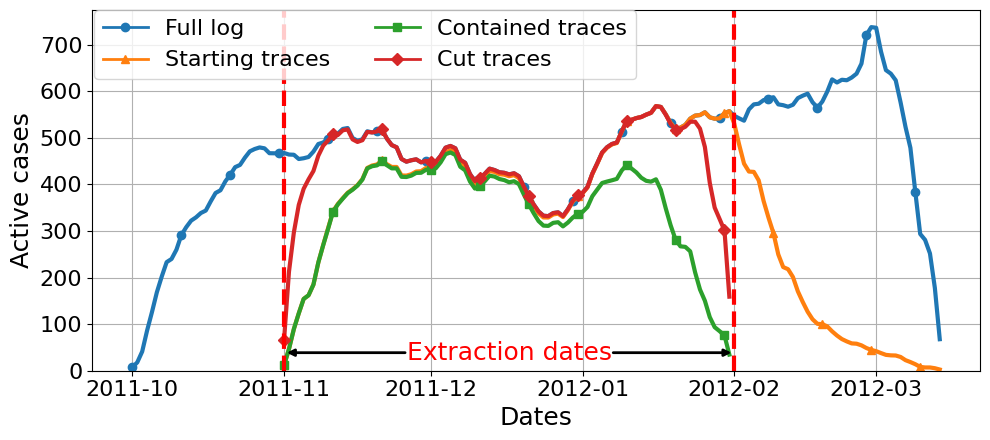

In [41]:
plot_metric(wipD, cut_dates, metric='wip')

In [42]:
# plot_metric(wipD, cut_dates, metric='wip', figtype='narrow')

#### Lead time

## Lead time in days Over Time


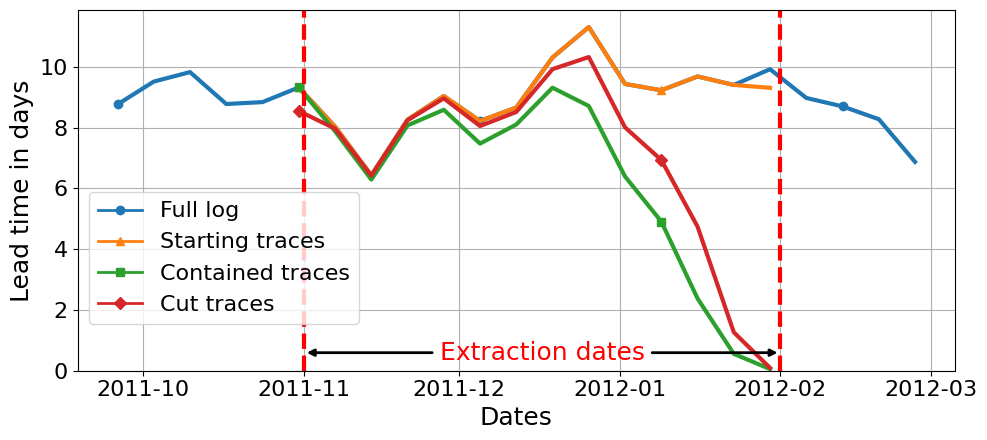

In [43]:
plot_metric(leadT, cut_dates, metric='lead_time')

In [44]:
# plot_metric(leadT, cut_dates, metric='lead_time', figtype='narrow')

#### Case length

## Case length in number of activities Over Time


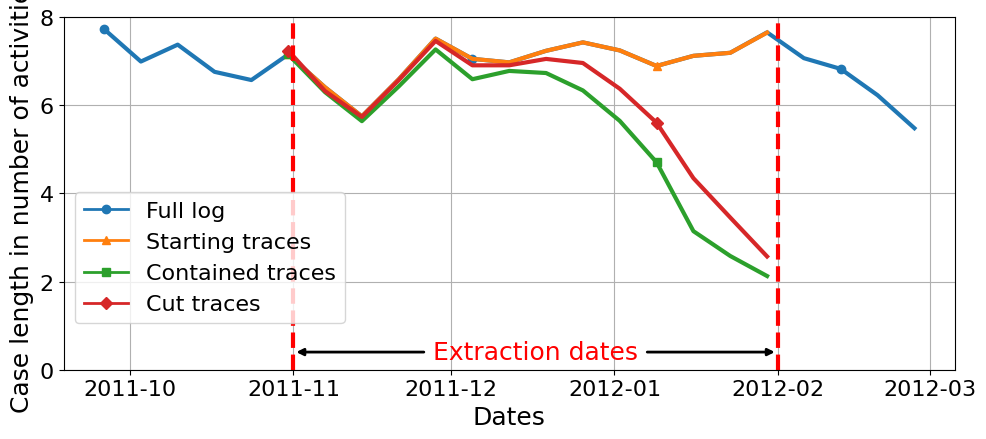

In [45]:
plot_metric(caseL, cut_dates, metric='case_length')

## Visualization splitting

### Set up

In [46]:

def plot_wip_for_splits(logs, log_ids, extraction_type, timedelta='D', cut_dates=None, marker_interval=10):
    # Define font sizes
    label_fontsize = 18
    title_fontsize = 20
    tick_fontsize = 16
    legend_fontsize = 14 #16
    # figsize = (10, 4.5)
    figsize = (8, 3.5)
    linewidth = 3  
    dpi = 600
    
    # Color and marker dictionary
    colors = {
        'full_log': '#000000',       # Black
        'regular': '#1f77b4',        # Blue
        'intermediate': '#2ca02c',   # Green
        'strict': '#ff7f0e',         # Orange
        'extraction_dates': '#d62728',  # Red
        'split_cases': '#d62728',  # Red
        'split_events': '#17becf'    # Cyan
    }
    markers = {'regular': 'o', 'intermediate': '^', 'strict': 's'}

    fig, ax = plt.subplots(figsize=figsize)  

    # Plot WIP for the full log as a reference
    full_log = logs['extractions'][extraction_type]
    full_timestamps, full_wip = get_wip(full_log, timedelta, log_ids)
    ax.plot(full_timestamps, full_wip, color=colors['full_log'], linestyle='-', linewidth=linewidth)
    
    # Adding markers at intervals on full_log
    ax.plot(full_timestamps[::marker_interval], full_wip[::marker_interval], color=colors['full_log'], linestyle='',
             marker='D', markersize=6)

    i = 0
    for method in ['regular', 'intermediate', 'strict']:
        # Retrieve train and test logs for the specified extraction type and split method
        train_log = logs['splits'][extraction_type][method]['train']
        test_log = logs['splits'][extraction_type][method]['test']

        # Calculate WIP values for both train and test logs
        train_timestamps, train_wip = get_wip(train_log, timedelta, log_ids)
        test_timestamps, test_wip = get_wip(test_log, timedelta, log_ids)

        # Offset WIP values slightly for visual separation
        train_wip = [v + i for v in train_wip]
        test_wip = [v + i for v in test_wip]

        # Plot train and test WIP values with continuous lines
        ax.plot(train_timestamps, train_wip, color=colors[method], linestyle='-', linewidth=linewidth)
        ax.plot(test_timestamps, test_wip, color=colors[method], linestyle='-', linewidth=linewidth)
        
        # Plot markers only at specified intervals
        ax.plot(train_timestamps[::marker_interval], train_wip[::marker_interval], color=colors[method],
                 linestyle='', marker=markers[method], markersize=6)
        ax.plot(test_timestamps[::marker_interval], test_wip[::marker_interval], color=colors[method],
                 linestyle='', marker=markers[method], markersize=6)
        
        i += 10
        if i>=30:
            i=20

    # Define cut lines
    split_regular_cut = pd.to_datetime('2012-01-13 00:00:00').tz_localize('UTC')

    # Add additional split lines
    ax.axvline(split_regular_cut, color=colors['split_cases'], linestyle='--', linewidth=linewidth)

    # Custom legend elements to include markers, lines, and cuts
    legend_elements = [
        Line2D([0], [0], color=colors['full_log'], lw=1.5, marker='D', markersize=6, label='Full log'),
        Line2D([0], [0], color=colors['regular'], lw=1.5, marker=markers['regular'], markersize=6, label='Regular split'),
        Line2D([0], [0], color=colors['intermediate'], lw=1.5, marker=markers['intermediate'], markersize=6, label='Intermediate\nsplit'),
        Line2D([0], [0], color=colors['strict'], lw=1.5, marker=markers['strict'], markersize=6, label='Strict split'),
    ]

    # Get y-axis limits from the axis object
    ylim = ax.get_ylim()
    
    # Annotate with the drift point arrow
    y_value =ylim[1] - 40
    ax.annotate('Splitting point', 
             xy=(split_regular_cut, y_value),  # Position at the bottom of the drift_time line
             xytext=(split_regular_cut - pd.Timedelta(days=20), y_value),  # Increase the distance to the left
             arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2),  # Horizontal arrow pointing to the left
             fontsize=legend_fontsize, color='red', va='center', ha='right')  # Align text to the right of the arrow

    # Label the axes and add a title
    ax.set_xlabel('Dates', fontsize=label_fontsize)
    ax.set_ylabel('Active cases', fontsize=label_fontsize)
    title = f'Active Cases Over Time - {extraction_type.capitalize()} Extraction Strategy'
    print(title)

    # Adjust tick font sizes
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Get x-tick positions and only keep every other one
    current_xticks = ax.get_xticks()
    new_xticks = current_xticks[::4]  # Select every other x-tick

    # Update x-ticks to only show every other label
    ax.set_xticks(new_xticks)

    # Add custom legend with markers, lines, and cut dates
    # ax.legend(handles=legend_elements, fontsize=legend_fontsize, ncol=1, loc='upper right', bbox_to_anchor=(1.01, 1.01))
    ax.legend(handles=legend_elements, fontsize=legend_fontsize, ncol=1, loc='lower left', bbox_to_anchor=(0.1, -0.035))
    ax.grid(True)
    plt.tight_layout()

    # Save the plot with transparent background (this will affect only the saved file)
    figure_name = 't3_bpi12_wip.pdf'
    output_path = os.path.join('..', 'figures', figure_name)
    plt.savefig(output_path, dpi=dpi, format='pdf')

    plt.show()


### Plot

/var/folders/x1/w2d1_9vs4497b2lw430zv8h40000gn/T/ipykernel_52148/1007889590.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log[event_log_ids.start_time] = pd.to_datetime(log[event_log_ids.start_time], format='mixed', utc=True)
/var/folders/x1/w2d1_9vs4497b2lw430zv8h40000gn/T/ipykernel_52148/1007889590.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log[event_log_ids.end_time] = pd.to_datetime(log[event_log_ids.end_time], format='mixed', utc=True)
/var/folders/x1/w2d1_9vs4497b2lw430zv8h40000gn/T/i

Active Cases Over Time - Starting Extraction Strategy


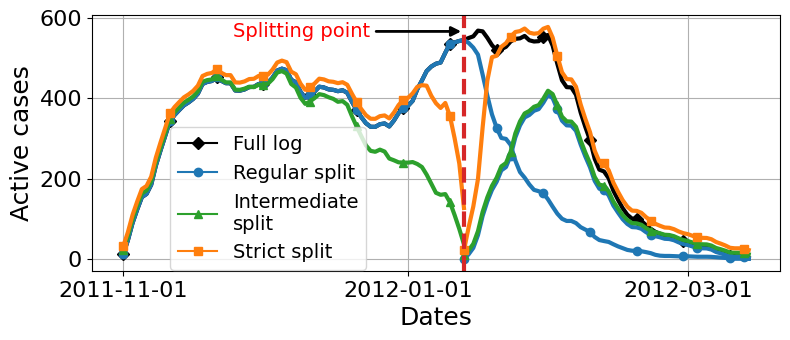

In [47]:
plot_wip_for_splits(logs[log_name], log_ids, 'starting', timedelta='D', cut_dates=[start_time, end_time])